# Predicting House Prices with Apache Spark and linear regression

In this we'll make use of the [California Housing](http://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html) data set. This dataset doesn't really need distributed computing, but it is great to show an example of how pyspark works. 

## 1. The Data

First appeared in a 1997 paper titled *Sparse Spatial Autoregressions*, written by Pace, R. Kelley and Ronald Barry and published in the Statistics and Probability Letters journal. Built with 1990 Census data. 

Every row contains data from a census block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people). A block includes on average 1425.5 individuals living in an area.

There are 20,640 observations on housing prices with 9 economic predictors.

The Median house value is the dependent variable and will be assigned the role of the target variable in our ML model.

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
# setting random seed for notebook reproducibility

rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

## 2. Create the Spark Session

In [ ]:
#we may want to compare speed performance by maxing out cpu partitions below

In [ ]:
spark = SparkSession.builder.master("local[2]").appName("Housing_price_predictions").getOrCreate()

In [ ]:
spark

In [ ]:
sc = spark.sparkContext
sc

<SparkContext master=local[2] appName=Housing_price_predictions>

In [ ]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:114: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


## 3. Load The Data From a File Into a Dataframe

In [ ]:
# !unzip "/cal_housing.data.zip" -d "housing_data"

In [ ]:
housing_data = '/content/housing_data'

Specifying the schema when loading data into a DataFrame will give better performance than schema inference.

In [ ]:
# define the schema, corresponding to a line in the csv data file.
schema = StructType([
    StructField("long", FloatType(), nullable=True),
    StructField("lat", FloatType(), nullable=True),
    StructField("medage", FloatType(), nullable=True),
    StructField("totrooms", FloatType(), nullable=True),
    StructField("totbdrms", FloatType(), nullable=True),
    StructField("pop", FloatType(), nullable=True),
    StructField("houshlds", FloatType(), nullable=True),
    StructField("medinc", FloatType(), nullable=True),
    StructField("medhv", FloatType(), nullable=True)]
)

In [ ]:
# Load housing data
census_housing = spark.read.csv(path=housing_data, schema=schema).cache()

In [ ]:
# Inspect first five rows
census_housing.take(5)

[Row(long=-122.2300033569336, lat=37.880001068115234, medage=41.0, totrooms=880.0, totbdrms=129.0, pop=322.0, houshlds=126.0, medinc=8.325200080871582, medhv=452600.0),
 Row(long=-122.22000122070312, lat=37.86000061035156, medage=21.0, totrooms=7099.0, totbdrms=1106.0, pop=2401.0, houshlds=1138.0, medinc=8.301400184631348, medhv=358500.0),
 Row(long=-122.23999786376953, lat=37.849998474121094, medage=52.0, totrooms=1467.0, totbdrms=190.0, pop=496.0, houshlds=177.0, medinc=7.257400035858154, medhv=352100.0),
 Row(long=-122.25, lat=37.849998474121094, medage=52.0, totrooms=1274.0, totbdrms=235.0, pop=558.0, houshlds=219.0, medinc=5.643099784851074, medhv=341300.0),
 Row(long=-122.25, lat=37.849998474121094, medage=52.0, totrooms=1627.0, totbdrms=280.0, pop=565.0, houshlds=259.0, medinc=3.8461999893188477, medhv=342200.0)]

In [ ]:
# Show first five rows
#need to figure out indexing...how can we look at bottom or arbitrary loc in structfield?
census_housing.show(5)


+-------+-----+------+--------+--------+------+--------+------+--------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|   medhv|
+-------+-----+------+--------+--------+------+--------+------+--------+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|452600.0|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|358500.0|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|352100.0|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|341300.0|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|342200.0|
+-------+-----+------+--------+--------+------+--------+------+--------+
only showing top 5 rows



In [ ]:
# show the dataframe columns
census_housing.columns

['long',
 'lat',
 'medage',
 'totrooms',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'medhv']

In [ ]:
# show the schema of the dataframe
census_housing.printSchema()

root
 |-- long: float (nullable = true)
 |-- lat: float (nullable = true)
 |-- medage: float (nullable = true)
 |-- totrooms: float (nullable = true)
 |-- totbdrms: float (nullable = true)
 |-- pop: float (nullable = true)
 |-- houshlds: float (nullable = true)
 |-- medinc: float (nullable = true)
 |-- medhv: float (nullable = true)



## 4. Data Exploration

### 4.1 Distribution of the median age of the people living in the area:

In [ ]:
# group by housing median age and see the distribution
result_df = census_housing.groupBy("medage").count().sort("medage", ascending=True)

In [ ]:
result_df.show(60)

+------+-----+
|medage|count|
+------+-----+
|   1.0|    4|
|   2.0|   58|
|   3.0|   62|
|   4.0|  191|
|   5.0|  244|
|   6.0|  160|
|   7.0|  175|
|   8.0|  206|
|   9.0|  205|
|  10.0|  264|
|  11.0|  254|
|  12.0|  238|
|  13.0|  302|
|  14.0|  412|
|  15.0|  512|
|  16.0|  771|
|  17.0|  698|
|  18.0|  570|
|  19.0|  502|
|  20.0|  465|
|  21.0|  446|
|  22.0|  399|
|  23.0|  448|
|  24.0|  478|
|  25.0|  566|
|  26.0|  619|
|  27.0|  488|
|  28.0|  471|
|  29.0|  461|
|  30.0|  476|
|  31.0|  458|
|  32.0|  565|
|  33.0|  615|
|  34.0|  689|
|  35.0|  824|
|  36.0|  862|
|  37.0|  537|
|  38.0|  394|
|  39.0|  369|
|  40.0|  304|
|  41.0|  296|
|  42.0|  368|
|  43.0|  353|
|  44.0|  356|
|  45.0|  294|
|  46.0|  245|
|  47.0|  198|
|  48.0|  177|
|  49.0|  134|
|  50.0|  136|
|  51.0|   48|
|  52.0| 1273|
+------+-----+



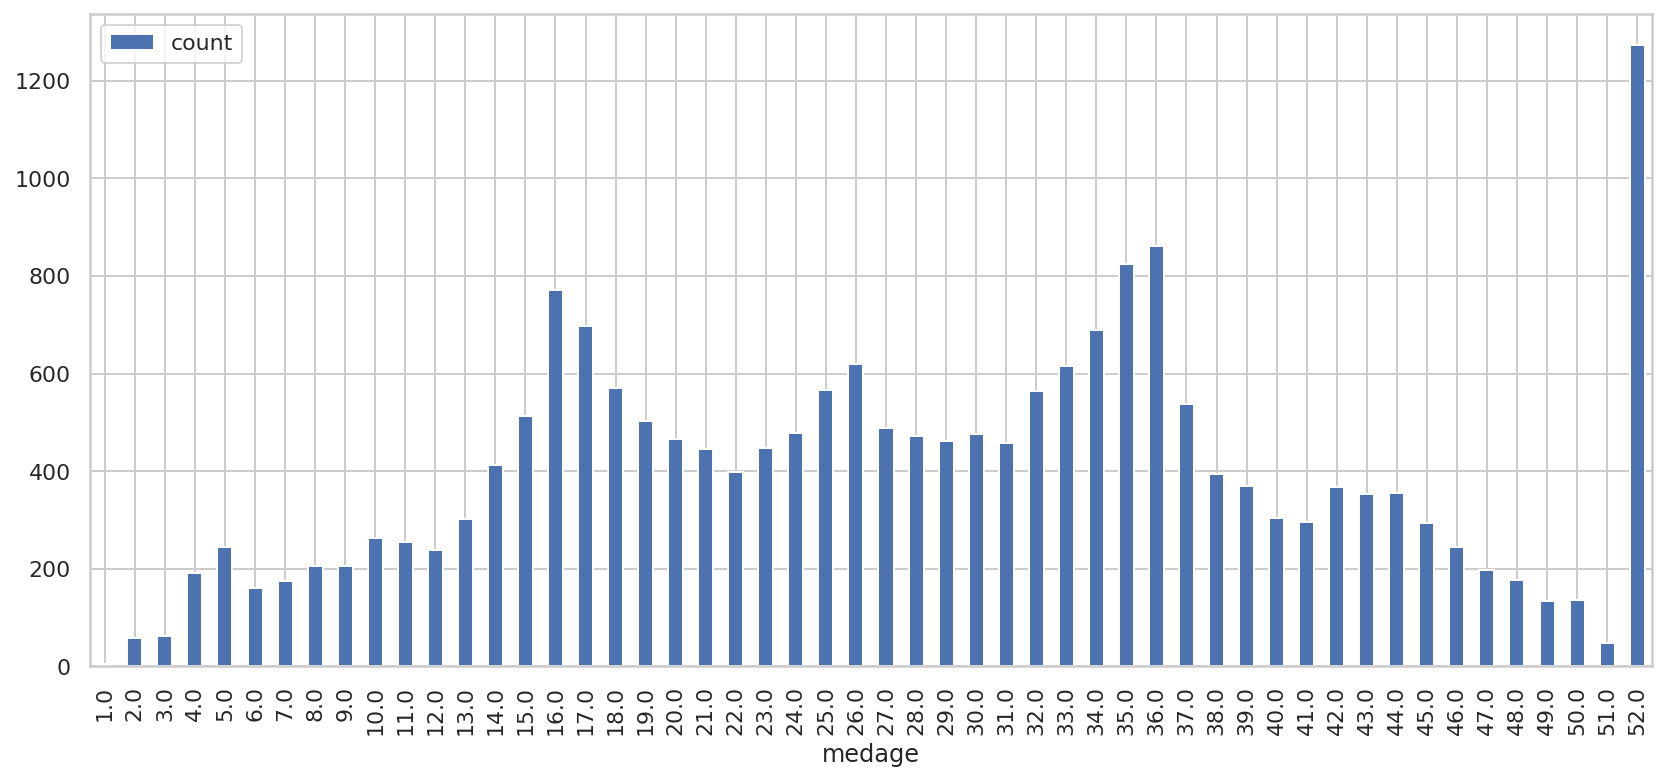

In [ ]:
result_df.toPandas().plot.bar(x='medage',figsize=(14, 6))


This is median age of the home.

### 4.2 Summary Statistics:

Spark DataFrames include some built-in functions for statistical processing. The describe() function performs summary statistics calculations on all numeric columns and returns them as a DataFrame.

In [ ]:
(census_housing.describe().select(
                    "summary",
                    F.round("medage", 4).alias("median home age"),
                    F.round("totrooms", 4).alias("total rooms"),
                    F.round("totbdrms", 4).alias("total bedrooms"),
                    F.round("pop", 4).alias("population"),
                    F.round("houshlds", 4).alias("households"),
                    F.round("medinc", 4).alias("median income"),
                    F.round("medhv", 4).alias("median home value"))
                    .show())

+-------+---------------+-----------+--------------+----------+----------+-------------+-----------------+
|summary|median home age|total rooms|total bedrooms|population|households|median income|median home value|
+-------+---------------+-----------+--------------+----------+----------+-------------+-----------------+
|  count|        20640.0|    20640.0|       20640.0|   20640.0|   20640.0|      20640.0|          20640.0|
|   mean|        28.6395|  2635.7631|       537.898| 1425.4767|  499.5397|       3.8707|      206855.8169|
| stddev|        12.5856|  2181.6153|      421.2479| 1132.4621|  382.3298|       1.8998|      115395.6159|
|    min|            1.0|        2.0|           1.0|       3.0|       1.0|       0.4999|          14999.0|
|    max|           52.0|    39320.0|        6445.0|   35682.0|    6082.0|      15.0001|         500001.0|
+-------+---------------+-----------+--------------+----------+----------+-------------+-----------------+



## 5. Data Preprocessing

With all this information that we gathered from our small exploratory data analysis, we know enough to preprocess our data to feed it to the model.

+ we shouldn't care about missing values; all zero values have been excluded from the data set.
+ We should probably standardize our data, as we have seen that the range of minimum and maximum values is quite big.
+ There are possibly some additional attributes that we could add, such as a feature that registers the number of bedrooms per room or the rooms per household.
+ Our dependent variable is also quite big; To make our life easier, we'll have to adjust the values slightly.

### 5.1 Preprocessing The Target Values
First, let's start with the `medianHouseValue`, our dependent variable. To facilitate our working with the target values, we will express the house values in units of 100,000. That means that a target such as `452600.000000` should become `4.526`:

In [ ]:
# Adjust the values of `medianHouseValue`
housing_df = census_housing.withColumn("medhv", col("medhv")/100000)

In [ ]:
# inspect
housing_df.show(2)

+-------+-----+------+--------+--------+------+--------+------+-----+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|
+-------+-----+------+--------+--------+------+--------+------+-----+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|4.526|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|3.585|
+-------+-----+------+--------+--------+------+--------+------+-----+
only showing top 2 rows



## 6. Feature Engineering
Now that we have adjusted the values in medianHouseValue, we will now add the following columns to the data set:

+ Rooms per household which refers to the number of rooms in households per block group;
+ Population per household, which basically gives us an indication of how many people live in households per block group; And
+ Bedrooms per room which will give us an idea about how many rooms are bedrooms per block group;

As we're working with DataFrames, we can best use the `select()` method to select the columns that we're going to be working with, namely `totalRooms`, `households`, and `population`. Additionally, we have to indicate that we're working with columns by adding the `col()` function to our code. Otherwise, we won't be able to do element-wise operations like the division that we have in mind for these three variables:

In [ ]:
housing_df.columns

['long',
 'lat',
 'medage',
 'totrooms',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'medhv']

In [ ]:
# Add the new columns to `df`

#add med income/medage for feature compression


housing_df = (housing_df.withColumn("rmsperhh", F.round(col("totrooms")/col("houshlds"), 5))
                       .withColumn("popperhh", F.round(col("pop")/col("houshlds"), 5))
                       .withColumn("bdrmsperrm", F.round(col("totbdrms")/col("totrooms"), 5)))
                
                      

In [ ]:
# Inspect the result
housing_df.show(5)

+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|rmsperhh|popperhh|bdrmsperrm|
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|4.526| 6.98413| 2.55556|   0.14659|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|3.585| 6.23814| 2.10984|    0.1558|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|3.521| 8.28814| 2.80226|   0.12952|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|3.413| 5.81735| 2.54795|   0.18446|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|3.422| 6.28185| 2.18147|    0.1721|
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
only showing top 5 rows



We can see that, for the first row, there are about 6.98 rooms per household, the households in the block group consist of about 2.5 people and the amount of bedrooms is quite low with 0.14:

We will use the `select()` method and pass the column names in the order that is more appropriate. In this case, the target variable medianHouseValue is put first, so that it won't be affected by the standardization.

In [ ]:
# Re-order and select columns

#may want to test compressed and then isolated features to determine effectiveness in test model performance. 

housing_df = housing_df.select('medhv','medinc', 'medage',"rmsperhh", "popperhh","bdrmsperrm")

### 6.1 Feature Extraction

We choose features to be normalized. 

Will also be important to test model performance with non-normalized features as well. 

In [ ]:
featureCols = ['medinc', 'medage', "rmsperhh", 
                              "popperhh", 
                              "bdrmsperrm"]

**Use a VectorAssembler to put features into a feature vector column:**

In [ ]:
# put features into a feature vector column
assembler = VectorAssembler(inputCols=featureCols, outputCol="features") 

In [ ]:
assembled_df = assembler.transform(housing_df)

# assembler?

In [ ]:
assembled_df.show(10, truncate=False)

+-----+------+------+--------+--------+----------+------------------------------------------------+
|medhv|medinc|medage|rmsperhh|popperhh|bdrmsperrm|features                                        |
+-----+------+------+--------+--------+----------+------------------------------------------------+
|4.526|8.3252|41.0  |6.98413 |2.55556 |0.14659   |[8.325200080871582,41.0,6.98413,2.55556,0.14659]|
|3.585|8.3014|21.0  |6.23814 |2.10984 |0.1558    |[8.301400184631348,21.0,6.23814,2.10984,0.1558] |
|3.521|7.2574|52.0  |8.28814 |2.80226 |0.12952   |[7.257400035858154,52.0,8.28814,2.80226,0.12952]|
|3.413|5.6431|52.0  |5.81735 |2.54795 |0.18446   |[5.643099784851074,52.0,5.81735,2.54795,0.18446]|
|3.422|3.8462|52.0  |6.28185 |2.18147 |0.1721    |[3.8461999893188477,52.0,6.28185,2.18147,0.1721]|
|2.697|4.0368|52.0  |4.76166 |2.1399  |0.23177   |[4.036799907684326,52.0,4.76166,2.1399,0.23177] |
|2.992|3.6591|52.0  |4.93191 |2.1284  |0.1929    |[3.65910005569458,52.0,4.93191,2.1284,0.1929]   |


Features columns are transformed into vectors. 

### 6.2 Standardization

Next, we can finally scale the data using `StandardScaler`. The input columns are the `features`, and the output column with the rescaled that will be included in the scaled_df will be named `"features_scaled"`:

In [ ]:
# Initialize the `standardScaler`
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")

May want to try other scaler methods to see how affects performance. 

In [ ]:
# standardScaler?

In [ ]:
# Fit the DataFrame to the scaler
scaled_df = standardScaler.fit(assembled_df).transform(assembled_df)

In [ ]:
# Inspect the result
scaled_df.select("features", "features_scaled").show(10, truncate=False)

+------------------------------------------------+------------------------------------------------------------------------------------------------+
|features                                        |features_scaled                                                                                 |
+------------------------------------------------+------------------------------------------------------------------------------------------------+
|[8.325200080871582,41.0,6.98413,2.55556,0.14659]|[4.38209543579743,3.2577023016083064,2.8228137890840155,0.24605698111193483,2.526390149647343]  |
|[8.301400184631348,21.0,6.23814,2.10984,0.1558] |[4.36956799913841,1.668579227653035,2.5213029554485034,0.20314172276495351,2.6851189393209363]  |
|[7.257400035858154,52.0,8.28814,2.80226,0.12952]|[3.820042673324032,4.131719992283705,3.349862599616386,0.2698099969833346,2.2321990052685985]   |
|[5.643099784851074,52.0,5.81735,2.54795,0.18446]|[2.970331231769803,4.131719992283705,2.351229973658551,0.24532

### 7. Building A Machine Learning Model With Spark ML


In [ ]:
# Split the data into train and test sets
#can always experiment with train test split. 

train_data, test_data = scaled_df.randomSplit([.85,.15], seed=rnd_seed)

We pass in a list with two numbers that represent the size that we want your training and test sets to have and a seed, which is needed for reproducibility reasons.

**Note** that the argument `elasticNetParam` corresponds to $\alpha$ or the vertical intercept and that the `regParam` or the regularization paramater corresponds to $\lambda$.

In [ ]:
train_data.columns

['medhv',
 'medinc',
 'medage',
 'rmsperhh',
 'popperhh',
 'bdrmsperrm',
 'features',
 'features_scaled']

**Create an ElasticNet model:**

ElasticNet is a linear regression model trained with L1 and L2 prior as regularizer. This combination allows for learning a sparse model where few of the weights are non-zero like Lasso, while still maintaining the regularization properties of Ridge. We control the convex combination of L1 and L2 using the l1_ratio parameter.

Elastic-net is useful when there are multiple features which are correlated with one another. Lasso is likely to pick one of these at random, while elastic-net is likely to pick both.

A practical advantage of trading-off between Lasso and Ridge is it allows Elastic-Net to inherit some of Ridge’s stability under rotation.

The objective function to minimize is in this case:
\begin{align}
min_w\frac{1}{2n_{samples}}{\parallel{X_w - y}\parallel}^2_2 + \alpha\lambda{\parallel{X_w - y}\parallel}_1 + \frac{\alpha(1-\lambda)}{2}{\parallel{w}\parallel}^2_2
\end{align}

http://scikit-learn.org/stable/modules/linear_model.html#elastic-net

In [ ]:
# Initialize `lr`
#looks like there is a standardization parameter that you can apply as part of the lr model. 

lr = (LinearRegression(featuresCol='features_scaled', labelCol="medhv", predictionCol='predmedhv', 
                               maxIter=10, regParam=0.3, elasticNetParam=0.8, standardization=False))

In [ ]:
%%time
# Fit the data to the model
linearModel = lr.fit(train_data)

CPU times: user 43.8 ms, sys: 5.79 ms, total: 49.6 ms
Wall time: 3.27 s


## 8. Evaluating the Model

With our model in place, we can generate predictions for our test data: use the `transform()` method to predict the labels for our `test_data`. Then, we can use RDD operations to extract the predictions as well as the true labels from the DataFrame.

### 8.1 Inspect the Model Co-efficients

In [ ]:
# Coefficients for the model
linearModel.coefficients

DenseVector([0.5267, 0.0, 0.0, 0.0, 0.0])

In [ ]:
featureCols

['medinc', 'medage', 'rmsperhh', 'popperhh', 'bdrmsperrm']

In [ ]:
# Intercept for the model
linearModel.intercept

0.996187847163548

In [ ]:
coeff_df = pd.DataFrame({"Feature": ["Intercept"] + featureCols, "Co-efficients": np.insert(linearModel.coefficients.toArray(), 0, linearModel.intercept)})
coeff_df = coeff_df[["Feature", "Co-efficients"]]

In [ ]:
coeff_df

,Feature,Co-efficients
0,Intercept,0.996188
1,medinc,0.526659
2,medage,0.000000
3,rmsperhh,0.000000
4,popperhh,0.000000
5,bdrmsperrm,0.000000


### 8.2 Generating Predictions

In [ ]:
# Generate predictions
predictions = linearModel.transform(test_data)

In [ ]:
# Extract the predictions and the "known" correct labels
predandlabels = predictions.select("predmedhv", "medhv")

In [ ]:
predandlabels.show()

+------------------+-------+
|         predmedhv|  medhv|
+------------------+-------+
|1.1447751288742525|0.14999|
|1.7377381486377572|  0.225|
|1.7484940937064375|  0.225|
|1.6048135068012424|  0.269|
|1.5910359778423766|  0.344|
|1.4943156174991816|  0.375|
|1.4239029707167492|  0.394|
| 1.525862673058386|  0.398|
|1.3213056670498151|  0.417|
|1.4794291433929645|  0.425|
| 1.431803622445099|   0.43|
|1.2569640628646852|  0.436|
|1.3302042934035743|   0.44|
| 1.590370617363288|   0.44|
|1.4289482960581568|  0.444|
|1.3642740281567884|  0.445|
|1.5181283779731145|  0.446|
|1.2341769866000358|   0.45|
| 1.453842209479038|  0.462|
|1.3418473086689455|  0.467|
+------------------+-------+
only showing top 20 rows



### 8.3 Inspect the Metrics

Looking at predicted values is one thing, but another and better thing is looking at some metrics to get a better idea of how good your model actually is.

**Using the `LinearRegressionModel.summary` attribute:**

Next, we can also use the `summary` attribute to pull up the `rootMeanSquaredError` and the `r2`.

In [ ]:
# Get the RMSE
print("RMSE: {0}".format(linearModel.summary.rootMeanSquaredError))

RMSE: 0.8787454363234394


In [ ]:
print("MAE: {0}".format(linearModel.summary.meanAbsoluteError))

MAE: 0.6753604308811815


In [ ]:
# Get the R2
print("R2: {0}".format(linearModel.summary.r2))

R2: 0.42080994840493


+ The RMSE measures how much error there is between two datasets comparing a predicted value and an observed or known value. The smaller an RMSE value, the closer predicted and observed values are.

+ The R2 ("R squared") or the coefficient of determination is a measure that shows how close the data are to the fitted regression line. This score will always be between 0 and a 100% (or 0 to 1 in this case), where 0% indicates that the model explains none of the variability of the response data around its mean, and 100% indicates the opposite: it explains all the variability. That means that, in general, the higher the R-squared, the better the model fits our data.

**Using the RegressionEvaluator from pyspark.ml package:**

In [ ]:
evaluator = RegressionEvaluator(predictionCol="predmedhv", labelCol='medhv', metricName='rmse')
print("RMSE: {0}".format(evaluator.evaluate(predandlabels)))

RMSE: 0.8802928078501595


In [ ]:
evaluator = RegressionEvaluator(predictionCol="predmedhv", labelCol='medhv', metricName='mae')
print("MAE: {0}".format(evaluator.evaluate(predandlabels)))

MAE: 0.6818618419497923


In [ ]:
evaluator = RegressionEvaluator(predictionCol="predmedhv", labelCol='medhv', metricName='r2')
print("R2: {0}".format(evaluator.evaluate(predandlabels)))

R2: 0.4137003675054528


**Using the RegressionMetrics from pyspark.mllib package:**

In [ ]:
# mllib is old so the methods are available in rdd
metrics = RegressionMetrics(predandlabels.rdd)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:159: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


In [ ]:
print("RMSE: {0}".format(metrics.rootMeanSquaredError))

RMSE: 0.8802928078501595


In [ ]:
print("MAE: {0}".format(metrics.meanAbsoluteError))

MAE: 0.6818618419497923


In [ ]:
print("R2: {0}".format(metrics.r2))

R2: 0.4137003675054528


In [ ]:
#end spark connection
spark.stop()

Now we should explore another data set -- cybersecurity salaries. This time, we can use elastic-net and some other models to compare performance. 

In [ ]:
salaries_data = '/content/salaries_cyber.csv'

In [ ]:
#read in data and inspect. Headings look good. 

salaries=spark.read.option("header","true").csv("/content/salaries_cyber.csv")
salaries.show(10,False)

Py4JJavaError: ignored

In [ ]:
salaries.printSchema

In [ ]:
#convert columns with numerals to float type
salaries.select(salaries.work_year.cast("float"),

salaries.salary.cast("float"),
 
salaries.salary_currency.cast("float"), 
salaries.salary_in_usd.cast('float'),
salaries.remote_ratio.cast('float'))


In [ ]:
year = salaries.orderBy("work_year", ascending=False)
year.show(15)

In [ ]:

salary_sort = salaries.orderBy('salary_in_usd', ascending=True)
salary_sort.show(100)